In [8]:
!pip install datasets transformers faiss-cpu --quiet


In [3]:
from datasets import load_dataset

# Load train and validation splits
train_ds = load_dataset("phiyodr/coco2017", split="train")
val_ds = load_dataset("phiyodr/coco2017", split="validation")

print(train_ds.features)
print(len(train_ds), len(val_ds))


{'license': Value(dtype='int64', id=None), 'file_name': Value(dtype='string', id=None), 'coco_url': Value(dtype='string', id=None), 'height': Value(dtype='int64', id=None), 'width': Value(dtype='int64', id=None), 'date_captured': Value(dtype='string', id=None), 'flickr_url': Value(dtype='string', id=None), 'image_id': Value(dtype='int64', id=None), 'ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'captions': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}
118287 5000


In [4]:
import os

# Show first 10 files in the train folder
train_files = os.listdir("/kaggle/input/coco-2017-dataset/coco2017/train2017")
print(train_files[:10])
print(len(train_files), "files in train2017")


['000000501175.jpg', '000000094632.jpg', '000000276721.jpg', '000000113282.jpg', '000000452819.jpg', '000000200857.jpg', '000000265134.jpg', '000000132042.jpg', '000000405580.jpg', '000000171272.jpg']
118287 files in train2017


In [5]:
print(train_ds[0]["file_name"])
print(train_ds[1]["file_name"])

train2017/000000391895.jpg
train2017/000000522418.jpg


In [6]:
COCO_ROOT = "/kaggle/input/coco-2017-dataset/coco2017"

def add_image_path(example):
    example["image_path"] = os.path.join(COCO_ROOT, example["file_name"])
    return example

train_ds = train_ds.map(add_image_path)
val_ds   = val_ds.map(add_image_path)

print(train_ds[0]["image_path"])
print(os.path.exists(train_ds[0]["image_path"]))


/kaggle/input/coco-2017-dataset/coco2017/train2017/000000391895.jpg
True


In [9]:
from transformers import CLIPProcessor
from PIL import Image
import torch

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


2025-08-11 13:28:49.495113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754918929.517647     271 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754918929.524460     271 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, processor):
        self.ds = hf_dataset
        self.processor = processor

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        image = Image.open(item["image_path"]).convert("RGB")
        
        # For now take only the first caption
        caption = item["captions"][0] if len(item["captions"]) > 0 else ""
        
        encoding = self.processor(
            text=caption,
            images=image,
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt"
        )

        # Remove batch dimension
        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0)
        }


In [11]:
from torch.utils.data import DataLoader

train_dataset = COCODataset(train_ds, processor)
val_dataset   = COCODataset(val_ds, processor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)


In [12]:
batch = next(iter(train_loader))
print("Image batch shape:", batch["pixel_values"].shape)   # (B, 3, 224, 224)
print("Token IDs shape:", batch["input_ids"].shape)        # (B, 32)
print("Attention mask shape:", batch["attention_mask"].shape)


Image batch shape: torch.Size([32, 3, 224, 224])
Token IDs shape: torch.Size([32, 32])
Attention mask shape: torch.Size([32, 32])


In [13]:

print("\nSanity-checking first 5 samples (shapes):")
for i in range(5):
    sample = train_dataset[i]
    print(f"sample {i} -> pixel_values: {sample['pixel_values'].shape}, input_ids: {sample['input_ids'].shape}")

batch = next(iter(train_loader))
print("\nBatch shapes from DataLoader (CPU):")
print("pixel_values:", batch["pixel_values"].shape)     # (B, 3, H, W)
print("input_ids:", batch["input_ids"].shape)           # (B, max_len)
print("attention_mask:", batch["attention_mask"].shape)


from transformers import CLIPTokenizerFast
tok = processor.tokenizer
example_ids = batch["input_ids"][0].tolist()
decoded = tok.decode([i for i in example_ids if i != tok.pad_token_id])
print("\nDecoded example caption (first batch element):", decoded)


Sanity-checking first 5 samples (shapes):
sample 0 -> pixel_values: torch.Size([3, 224, 224]), input_ids: torch.Size([32])
sample 1 -> pixel_values: torch.Size([3, 224, 224]), input_ids: torch.Size([32])
sample 2 -> pixel_values: torch.Size([3, 224, 224]), input_ids: torch.Size([32])
sample 3 -> pixel_values: torch.Size([3, 224, 224]), input_ids: torch.Size([32])
sample 4 -> pixel_values: torch.Size([3, 224, 224]), input_ids: torch.Size([32])

Batch shapes from DataLoader (CPU):
pixel_values: torch.Size([32, 3, 224, 224])
input_ids: torch.Size([32, 32])
attention_mask: torch.Size([32, 32])

Decoded example caption (first batch element): <|startoftext|>a stack of suitcases rest beside a couch .


In [15]:
import torch
from torch.optim import AdamW
from transformers import CLIPModel
from torch.cuda.amp import autocast, GradScaler
import time
import os

# Config
model_name = "openai/clip-vit-base-patch32"
epochs = 3
batch_log_interval = 50            # print every N batches
subset_max_samples = 10000         # set to None to use whole train set; use smaller for quick tests
save_dir = "/kaggle/working/clip_finetuned"
os.makedirs(save_dir, exist_ok=True)
lr = 1e-4                          # higher lr ok since only small heads are trained
weight_decay = 0.01
use_amp = True

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load CLIP
model = CLIPModel.from_pretrained(model_name)
# Freeze everything
for p in model.parameters():
    p.requires_grad = False

# Unfreeze projection heads and logit scale
unfreeze_names = []
if hasattr(model, "visual_projection"):
    model.visual_projection.requires_grad = True
    unfreeze_names.append("visual_projection")
if hasattr(model, "text_projection"):
    model.text_projection.requires_grad = True
    unfreeze_names.append("text_projection")
# logit_scale is a parameter (learnable scalar)
if hasattr(model, "logit_scale"):
    model.logit_scale.requires_grad = True
    unfreeze_names.append("logit_scale")

# As a fallback if attribute names differ, try to unfreeze modules by name
# (This is defensive; typically HF CLIPModel uses text_projection & visual_projection.)
for name, module in model.named_modules():
    if name.endswith("projection") or "proj" in name:
        for p in module.parameters():
            p.requires_grad = True
        unfreeze_names.append(name)

print("Unfrozen modules (partial list):", list(dict.fromkeys(unfreeze_names))[:10])

model = model.to(device)

# Build optimizer with only params that require grad
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(trainable_params, lr=lr, weight_decay=weight_decay)

# Amp scaler
scaler = GradScaler() if use_amp else None

Device: cuda
Unfrozen modules (partial list): ['visual_projection', 'text_projection', 'logit_scale', 'text_model.encoder.layers.0.self_attn.k_proj', 'text_model.encoder.layers.0.self_attn.v_proj', 'text_model.encoder.layers.0.self_attn.q_proj', 'text_model.encoder.layers.0.self_attn.out_proj', 'text_model.encoder.layers.1.self_attn.k_proj', 'text_model.encoder.layers.1.self_attn.v_proj', 'text_model.encoder.layers.1.self_attn.q_proj']


/tmp/ipykernel_271/3605194009.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


In [16]:
if subset_max_samples is not None:
    # Build a subset dataloader view
    from torch.utils.data import Subset
    subset_size = min(subset_max_samples, len(train_dataset))
    subset_idx = list(range(subset_size))
    train_subset = torch.utils.data.Subset(train_dataset, subset_idx)
    train_loader_ft = torch.utils.data.DataLoader(train_subset, batch_size=train_loader.batch_size,
                                                  shuffle=True, num_workers=2, pin_memory=True)
    print(f"Using subset of train: {subset_size} samples")
else:
    train_loader_ft = train_loader

# Training loop (using CLIPModel's built-in contrastive loss via return_loss=True)
def train_one_epoch(epoch_idx):
    model.train()
    running_loss = 0.0
    n_batches = 0
    start = time.time()
    for batch_idx, batch in enumerate(train_loader_ft):
        pixel_values = batch["pixel_values"].to(device, dtype=torch.float32)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        optimizer.zero_grad()
        # Mixed precision forward/backward
        if use_amp:
            with autocast():
                outputs = model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                pixel_values=pixel_values,
                                return_loss=True)
                loss = outputs.loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            pixel_values=pixel_values,
                            return_loss=True)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        n_batches += 1

        if (batch_idx + 1) % batch_log_interval == 0:
            avg_loss = running_loss / n_batches
            elapsed = time.time() - start
            print(f"[Epoch {epoch_idx+1}] Batch {batch_idx+1} | AvgLoss: {avg_loss:.4f} | Elapsed: {elapsed:.1f}s")
    epoch_loss = running_loss / max(1, n_batches)
    print(f"*** Epoch {epoch_idx+1} finished. Avg loss: {epoch_loss:.4f} | Time: {time.time()-start:.1f}s")
    return epoch_loss

# Run training (lightweight)
for epoch in range(epochs):
    loss = train_one_epoch(epoch)
    # Save checkpoint
    ckpt_path = os.path.join(save_dir, f"clip_finetuned_epoch{epoch+1}.pt")
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss
    }, ckpt_path)
    print("Saved checkpoint:", ckpt_path)

print("Fine-tune finished. Model saved under", save_dir)

Using subset of train: 10000 samples


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_271/3620744031.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1] Batch 50 | AvgLoss: 0.3902 | Elapsed: 17.9s
[Epoch 1] Batch 100 | AvgLoss: 0.3852 | Elapsed: 34.4s
[Epoch 1] Batch 150 | AvgLoss: 0.3892 | Elapsed: 50.8s
[Epoch 1] Batch 200 | AvgLoss: 0.3972 | Elapsed: 67.0s
[Epoch 1] Batch 250 | AvgLoss: 0.4043 | Elapsed: 83.6s
[Epoch 1] Batch 300 | AvgLoss: 0.4063 | Elapsed: 100.2s
*** Epoch 1 finished. Avg loss: 0.4059 | Time: 104.3s
Saved checkpoint: /kaggle/working/clip_finetuned/clip_finetuned_epoch1.pt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Epoch 2] Batch 50 | AvgLoss: 0.2578 | Elapsed: 10.9s
[Epoch 2] Batch 100 | AvgLoss: 0.2403 | Elapsed: 21.2s
[Epoch 2] Batch 150 | AvgLoss: 0.2517 | Elapsed: 32.0s
[Epoch 2] Batch 200 | AvgLoss: 0.2525 | Elapsed: 42.5s
[Epoch 2] Batch 250 | AvgLoss: 0.2538 | Elapsed: 52.9s
[Epoch 2] Batch 300 | AvgLoss: 0.2586 | Elapsed: 63.7s
*** Epoch 2 finished. Avg loss: 0.2603 | Time: 66.2s
Saved checkpoint: /kaggle/working/clip_finetuned/clip_finetuned_epoch2.pt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Epoch 3] Batch 50 | AvgLoss: 0.2139 | Elapsed: 11.0s
[Epoch 3] Batch 100 | AvgLoss: 0.1959 | Elapsed: 21.5s
[Epoch 3] Batch 150 | AvgLoss: 0.2014 | Elapsed: 32.1s
[Epoch 3] Batch 200 | AvgLoss: 0.2078 | Elapsed: 42.5s
[Epoch 3] Batch 250 | AvgLoss: 0.2167 | Elapsed: 52.9s
[Epoch 3] Batch 300 | AvgLoss: 0.2198 | Elapsed: 63.6s
*** Epoch 3 finished. Avg loss: 0.2200 | Time: 66.3s
Saved checkpoint: /kaggle/working/clip_finetuned/clip_finetuned_epoch3.pt
Fine-tune finished. Model saved under /kaggle/working/clip_finetuned


In [24]:
# After training loop finishes
save_path = "/kaggle/working/clip_finetuned"
model.save_pretrained(save_path)
processor.save_pretrained(save_path)

print(f"Model and processor saved to {save_path}")


Model and processor saved to /kaggle/working/clip_finetuned


In [26]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load fine-tuned model
model_path = "/kaggle/working/clip_finetuned/clip_finetuned_epoch3.pt"
base_model_name = "openai/clip-vit-base-patch32"

# Load original CLIP architecture
model = CLIPModel.from_pretrained(base_model_name)
state_dict = torch.load(model_path, map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.eval()

# Load processor
processor = CLIPProcessor.from_pretrained(base_model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Test image
image = Image.open("/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000001.jpg")  # Example image
# Candidate captions
candidate_texts = [
    "A group of people playing baseball.",
    "A child is riding a horse.",
    "A kitchen with modern appliances.",
    "A dog running through the grass.",
    "a taxi parked on the street"
]

# Preprocess
inputs = processor(
    text=candidate_texts,
    images=image,
    return_tensors="pt",
    padding=True
).to(device)

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # similarity score (1 image × N captions)
    probs = logits_per_image.softmax(dim=1)      # convert to probabilities

# Show results
for text, prob in zip(candidate_texts, probs[0]):
    print(f"{text} -> {prob.item()*100:.2f}%")


A group of people playing baseball. -> 0.00%
A child is riding a horse. -> 0.01%
A kitchen with modern appliances. -> 0.00%
A dog running through the grass. -> 0.01%
a taxi parked on the street -> 99.98%


In [27]:
import torch
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
from PIL import Image
import os

# --- Configuration ---
MODEL_PATH = "/kaggle/working/clip_finetuned"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
COCO_ROOT = "/kaggle/input/coco-2017-dataset/coco2017"

# --- Load Model and Processor ---
# Load the fine-tuned model from the path where you saved it
model = CLIPModel.from_pretrained(MODEL_PATH).to(DEVICE)
processor = CLIPProcessor.from_pretrained(MODEL_PATH)

# --- Load the Image Collection (COCO validation set) ---
# This dataset will be our searchable image gallery
val_ds = load_dataset("phiyodr/coco2017", split="validation")

# Add the full image path to each entry
def add_image_path(example):
    example["image_path"] = os.path.join(COCO_ROOT, example["file_name"])
    return example

val_ds = val_ds.map(add_image_path)

print(f"Loaded model from {MODEL_PATH} and {len(val_ds)} images for the search gallery.")

Loaded model from /kaggle/working/clip_finetuned and 5000 images for the search gallery.


In [28]:
import faiss
import numpy as np
from tqdm import tqdm

# Dimension of the CLIP embeddings
d = model.config.projection_dim 
# Create a FAISS index
faiss_index = faiss.IndexFlatL2(d)

# --- Function to get image embeddings ---
def get_image_embedding(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)
        image_embedding = model.get_image_features(**inputs)
        # Normalize the embedding
        image_embedding /= image_embedding.norm(p=2, dim=-1, keepdim=True)
    return image_embedding.cpu().numpy()

# --- Populate the index ---
print("Generating embeddings and building the FAISS index...")

# store the original dataset index to retrieve the image later
image_indices = []

# Using a dataloader for batching can speed this up, but iterating is clearer
for i, item in enumerate(tqdm(val_ds)):
    try:
        image = Image.open(item["image_path"]).convert("RGB")
        embedding = get_image_embedding(image)
        faiss_index.add(embedding)
        image_indices.append(i) # Store the original index
    except Exception as e:
        print(f"Skipping image {i} due to error: {e}")

print(f"FAISS index built successfully with {faiss_index.ntotal} image embeddings.")

Generating embeddings and building the FAISS index...




  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 1/5000 [00:00<09:04,  9.18it/s]

  0%|          | 4/5000 [00:00<04:51, 17.14it/s]

  0%|          | 6/5000 [00:00<04:35, 18.12it/s]

  0%|          | 8/5000 [00:00<04:42, 17.66it/s]

  0%|          | 10/5000 [00:00<04:33, 18.27it/s]

  0%|          | 13/5000 [00:00<03:52, 21.45it/s]

  0%|          | 16/5000 [00:00<03:27, 23.99it/s]

  0%|          | 19/5000 [00:00<03:13, 25.72it/s]

  0%|          | 22/5000 [00:00<03:12, 25.84it/s]

  0%|          | 25/5000 [00:01<03:07, 26.49it/s]

  1%|          | 28/5000 [00:01<03:08, 26.40it/s]

  1%|          | 31/5000 [00:01<03:12, 25.82it/s]

  1%|          | 34/5000 [00:01<03:05, 26.84it/s]

  1%|          | 37/5000 [00:01<02:59, 27.68it/s]

  1%|          | 40/5000 [00:01<02:58, 27.73it/s]

  1%|          | 43/5000 [00:01<02:59, 27.68it/s]

  1%|          | 46/5000 [00:01<03:10, 26.05it/s]

  1%|          | 49/5000 [00:02<03:15, 25.31it/s]

  1%|          | 52/5000 [00:02<03:33, 23.

FAISS index built successfully with 5000 image embeddings.



Top search results for: 'a person riding a motorcycle on a street'


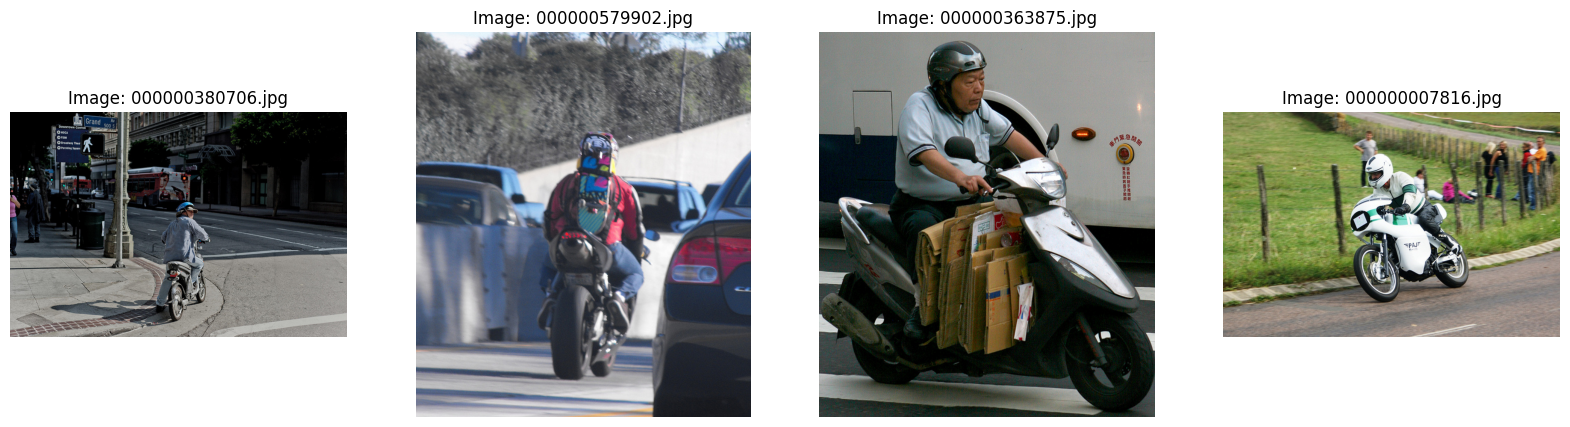


Top search results for: 'a plate of fruit on a table'


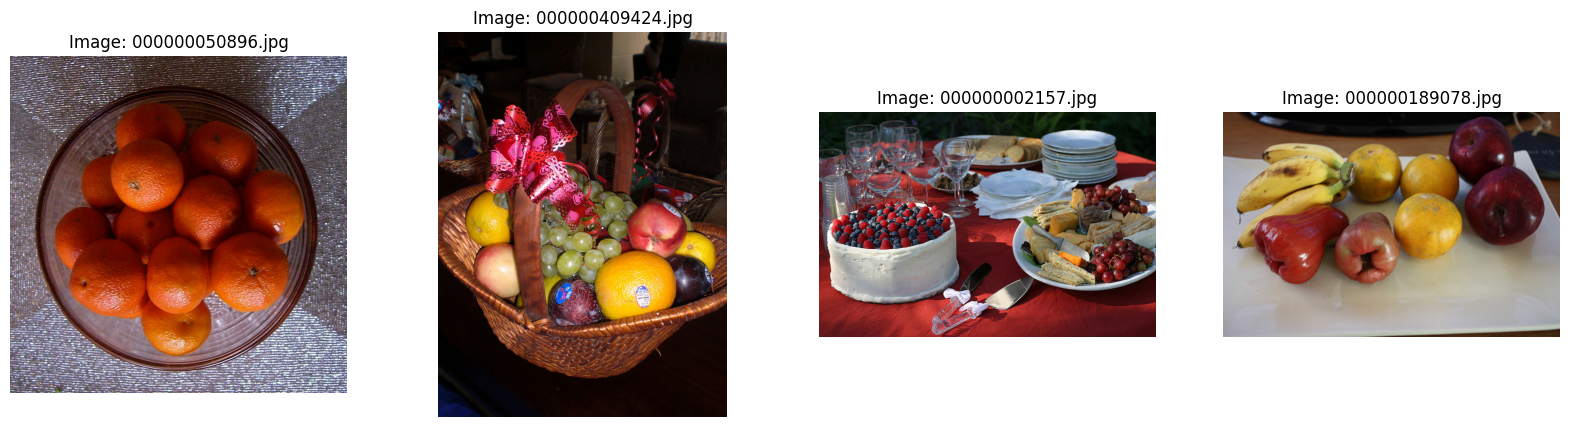

In [29]:
import matplotlib.pyplot as plt

# --- Function to get text embeddings ---
def get_text_embedding(text):
    with torch.no_grad():
        inputs = processor(text=text, return_tensors="pt").to(DEVICE)
        text_embedding = model.get_text_features(**inputs)
        # Normalize the embedding
        text_embedding /= text_embedding.norm(p=2, dim=-1, keepdim=True)
    return text_embedding.cpu().numpy()

# --- The Search Function ---
def search(query, top_k=5):
    """
    Takes a text query and returns the top_k most similar images.
    """
    # 1. Get the text embedding
    text_embedding = get_text_embedding(query)

    # 2. Search the FAISS index
    # D contains distances, I contains the indices of the nearest neighbors
    distances, indices = faiss_index.search(text_embedding, top_k)

    # 3. Retrieve and return the results
    results = [val_ds[image_indices[i]] for i in indices[0]]
    return results

# --- Let's try it out! ---
search_query = "a person riding a motorcycle on a street"
search_results = search(search_query, top_k=4)

print(f"\nTop search results for: '{search_query}'")

# --- Display Results ---
fig, axes = plt.subplots(1, len(search_results), figsize=(20, 5))
for i, result in enumerate(search_results):
    image = Image.open(result["image_path"]).convert("RGB")
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {os.path.basename(result['file_name'])}")
    axes[i].axis("off")
plt.show()

# --- Another Example ---
search_query = "a plate of fruit on a table"
search_results = search(search_query, top_k=4)
print(f"\nTop search results for: '{search_query}'")
fig, axes = plt.subplots(1, len(search_results), figsize=(20, 5))
for i, result in enumerate(search_results):
    image = Image.open(result["image_path"]).convert("RGB")
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {os.path.basename(result['file_name'])}")
    axes[i].axis("off")
plt.show()

In [32]:
import os
import zipfile
from IPython.display import FileLink

# --- Configuration ---
# Directory where your final model files are saved
MODEL_DIR = "/kaggle/working/clip_finetuned/"
# The name of the zip file you want to create
ZIP_NAME = "deployment_files.zip"
# Path for the final zip file
ZIP_PATH = f"/kaggle/working/{ZIP_NAME}"

# --- List of essential files to include ---
# These are the files created by `save_pretrained`. We exclude the .pt checkpoints.
essential_files = [
    "config.json",
    "merges.txt",
    "model.safetensors", # or "pytorch_model.bin"
    "preprocessor_config.json",
    "special_tokens_map.json",
    "tokenizer.json",
    "tokenizer_config.json",
    "vocab.json"
]

# --- Create the Zip Archive ---
print(f"Creating zip file: {ZIP_NAME}")

with zipfile.ZipFile(ZIP_PATH, 'w') as zipf:
    for file_name in essential_files:
        file_path = os.path.join(MODEL_DIR, file_name)
        if os.path.exists(file_path):
            # The second argument in arcname ensures files aren't nested inside the 'clip_finetuned' folder in the zip
            zipf.write(file_path, arcname=os.path.join('clip_finetuned', file_name))
            print(f"Added: {file_name}")
        else:
            print(f"Warning: Could not find {file_name}")

print("\nZip file created successfully!")

Creating zip file: deployment_files.zip
Added: config.json
Added: merges.txt
Added: model.safetensors
Added: preprocessor_config.json
Added: special_tokens_map.json
Added: tokenizer.json
Added: tokenizer_config.json
Added: vocab.json

Zip file created successfully!
Click the link below to download your files:


/kaggle/working/deployment_files.zip

In [35]:
import os


IMAGE_DIR_FULL_PATH = "/kaggle/input/coco-2017-dataset/coco2017/val2017"

# The output text file
OUTPUT_FILE_PATH = "/kaggle/working/image_paths.txt"

# --- Generate the file list ---
try:
    # Get all filenames from the validation directory and sort them
    # Sorting ensures the order is consistent if you ever need to rebuild the index
    filenames = sorted(os.listdir(IMAGE_DIR_FULL_PATH))
    
    # Write each filename to the text file, one per line
    with open(OUTPUT_FILE_PATH, 'w') as f:
        for name in filenames:
            f.write(name + '\n')
            
    print(f"Successfully created 'image_paths.txt' with {len(filenames)} entries.")
    print(f"File saved to: {OUTPUT_FILE_PATH}")

except FileNotFoundError:
    print(f"Error: The directory was not found at '{IMAGE_DIR_FULL_PATH}'")
    print("Please make sure the path to your validation images is correct.")

Successfully created 'image_paths.txt' with 5000 entries.
File saved to: /kaggle/working/image_paths.txt


In [45]:
import gradio as gr
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
import faiss
from datasets import load_dataset
import requests 
import io

# --- Configuration ---
MODEL_PATH = "clip_finetuned" 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FAISS_INDEX_PATH = "gallery.index"

# --- Load Model, Processor, and FAISS Index ---
print("Loading model and processor...")
model = CLIPModel.from_pretrained(MODEL_PATH).to(DEVICE)
processor = CLIPProcessor.from_pretrained(MODEL_PATH)

print("Loading FAISS index...")
faiss_index = faiss.read_index(FAISS_INDEX_PATH)

# --- Connect to the COCO dataset on the Hub ---
print("Connecting to COCO dataset on the Hub...")
val_dataset = load_dataset("phiyodr/coco2017", split="validation", trust_remote_code=True)
    
print(f"Successfully connected to dataset with {len(val_dataset)} images.")

# --- The Search Function (Corrected) ---
def image_search(query_text: str, top_k: int):
    with torch.no_grad():
        inputs = processor(text=query_text, return_tensors="pt").to(DEVICE)
        text_embedding = model.get_text_features(**inputs)
        text_embedding /= text_embedding.norm(p=2, dim=-1, keepdim=True)

    distances, indices = faiss_index.search(text_embedding.cpu().numpy(), int(top_k))

    # --- CORRECTED LOGIC ---
    # For each result, get its URL from the dataset, download it, and open it as an image.
    results = []
    for i in indices[0]:
        item = val_dataset[int(i)]
        image_url = item['coco_url']
        response = requests.get(image_url)
        image = Image.open(io.BytesIO(response.content)).convert("RGB")
        results.append(image)
        
    return results

# --- Gradio Interface (No changes needed here) ---
with gr.Blocks(theme=gr.themes.Soft()) as iface:
    gr.Markdown("# 🖼️ CLIP-Powered Image Search Engine")
    gr.Markdown("Enter a text description to search for matching images.")
    
    with gr.Row():
        query_input = gr.Textbox(label="Search Query", placeholder="e.g., a red car parked near a building", scale=4)
        k_slider = gr.Slider(minimum=1, maximum=12, value=4, step=1, label="Number of Results")
        submit_btn = gr.Button("Search", variant="primary")

    gallery_output = gr.Gallery(label="Search Results", show_label=False, columns=4, height="auto")

    submit_btn.click(fn=image_search, inputs=[query_input, k_slider], outputs=gallery_output)
    
    gr.Examples(
        examples=[["a dog catching a frisbee", 4], ["two people eating pizza", 8]],
        inputs=[query_input, k_slider]
    )

iface.launch()

Loading model and processor...
Loading FAISS index...
Connecting to COCO dataset on the Hub...
Successfully connected to dataset with 5000 images.
* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://03f9902e3aa88b93b9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
